In [4]:
#Importing all the library

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re
%matplotlib inline

In [5]:
mails = pd.read_csv('spam.csv', encoding = 'latin-1')      #loading the data into mails
mails.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
mails.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True) #dropping the unknown columns from the data
mails.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
mails.rename(columns = {'v1': 'labels', 'v2': 'message'}, inplace = True)    #renaming the columns of the data
mails.head()

,labels,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
mails['labels'].value_counts()           #counting the total number of ham and spam mails

ham     4825
spam     747
Name: labels, dtype: int64

In [9]:
mails['label'] = mails['labels'].map({'ham': 0, 'spam': 1})             #spam:1, ham:0
mails.head()

,labels,message,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [10]:
mails.drop(['labels'], axis = 1, inplace = True)                # dropping the column having name of the classes of mails      
mails.head()

,message,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [11]:
totalMails = 4825 + 747
trainIndex, testIndex = list(), list()              #splitting the training and testing data
for i in range(mails.shape[0]):
    if np.random.uniform(0, 1) < 0.70:
        trainIndex += [i]
    else:
        testIndex += [i]
trainData = mails.loc[trainIndex]
testData = mails.loc[testIndex]

In [12]:
trainData.reset_index(inplace = True)
trainData.drop(['index'], axis = 1, inplace = True)
trainData.head()

,message,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [13]:
testData.reset_index(inplace = True)
testData.drop(['index'], axis = 1, inplace = True)
testData.head()

,message,label
0,FreeMsg Hey there darling it's been 3 week's n...,1
1,WINNER!! As a valued network customer you have...,1
2,"XXXMobileMovieClub: To use your credit, click ...",1
3,Fine if thatåÕs the way u feel. ThatåÕs the wa...,0
4,England v Macedonia - dont miss the goals/team...,1


In [14]:
trainData['label'].value_counts()             #coutning no. of spam and ham emails in training data

0    3364
1     511
Name: label, dtype: int64

In [15]:
testData['label'].value_counts()               #coutning no. of spam and ham emails in test data

0    1461
1     236
Name: label, dtype: int64

In [18]:
trainData.head()              #training data

,message,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [20]:
testData.head() #test data

,message,label
0,FreeMsg Hey there darling it's been 3 week's n...,1
1,WINNER!! As a valued network customer you have...,1
2,"XXXMobileMovieClub: To use your credit, click ...",1
3,Fine if thatåÕs the way u feel. ThatåÕs the wa...,0
4,England v Macedonia - dont miss the goals/team...,1


In [22]:
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):      #processing the mail
    if lower_case: 
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    return words

In [23]:
class SpamClassifier(object):
    def __init__(self, trainData, method = 'tf-idf'):
        self.mails, self.labels = trainData['message'], trainData['label']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):                  #bag of words            
        self.prob_spam = dict()
        self.prob_ham = dict()
        
        #P(w/spam) =(TF(w/spam) + 1 ) /  [(sum(word x in train dataset) TF(x)) + total no. of words in spam train dataset] 
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word] + 1) / (self.spam_words + \
                                                                len(list(self.tf_spam.keys())))
        #P(w/ham) =(TF(w/ham) + 1 ) /  [(sum(word x in train dataset) TF(x)) + total no. of words in spam train dataset] 
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word] + 1) / (self.ham_words + \
                                                                len(list(self.tf_ham.keys())))
            
            
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 


    def calc_TF_and_IDF(self):
        noOfMessages = self.mails.shape[0]
        self.spam_mails, self.ham_mails = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_mails = self.spam_mails + self.ham_mails
        self.spam_words = 0
        self.ham_words = 0
        self.tf_spam = dict()    #word : total no. of occurence of word in spam msgs
        self.tf_ham = dict()     #word : total no. of occurence of word in ham msgs
        self.idf_spam = dict()  #word : total no. of spam msgs containing word
        self.idf_ham = dict()  #word : total no. of ham msgs containing word
        for i in range(noOfMessages):
            message_processed = process_message(self.mails[i])
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF
            for word in message_processed:
                if self.labels[i]:
                    self.tf_spam[word] = self.tf_spam.get(word, 0) + 1       #word:total no of occurrences of word in the spam msgs
                    self.spam_words += 1                                     #word: total no. words in of spam msgs
                else:
                    self.tf_ham[word] = self.tf_ham.get(word, 0) + 1         #word:total no of occurrences of word in the ham msgs
                    self.ham_words += 1                                      #word: total no. words in of spam msgs
                if word not in count:   
                    count += [word]              #unique words
            for word in count:
                if self.labels[i]:
                    self.idf_spam[word] = self.idf_spam.get(word, 0) + 1          #word : total no. of spam msgs containing word
                else:
                    self.idf_ham[word] = self.idf_ham.get(word, 0) + 1            #word : total no. of ham msgs containing word

    def calc_TF_IDF(self):       #tf-idf methof
        self.prob_spam = dict()        # word : P(w/spam)
        self.prob_ham = dict()         # word : P(w/ham)
        self.sum_tf_idf_spam = 0
        self.sum_tf_idf_ham = 0
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam[word] + self.idf_ham.get(word, 0)))  #TF(w/spam)*IDF(w)
            self.sum_tf_idf_spam += self.prob_spam[word]
        for word in self.tf_spam:
            self.prob_spam[word] = (self.prob_spam[word] + 1) / (self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
                                                          #P(w/spam) = (TF(w/spam)*IDF(w) + 1) /  (sum(word x in train dataset) 
                                                                #(TF(x) * IDF(x)) + total no. of words in spam train dataset)
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam.get(word, 0) + self.idf_ham[word])) #TF(w/ham)*IDF(w)
            self.sum_tf_idf_ham += self.prob_ham[word]
        for word in self.tf_ham:
            self.prob_ham[word] = (self.prob_ham[word] + 1) / (self.sum_tf_idf_ham + len(list(self.prob_ham.keys())))  #P(w/ham)
            
    
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 
                                                                                #probabilities of spam and ham mail respectively
    def classify(self, processed_message):
        pSpam, pHam = 0, 0
        for word in processed_message:                
            if word in self.prob_spam:
                pSpam += log(self.prob_spam[word])                                # P(spam|message)
            else:
                if self.method == 'tf-idf':
                    pSpam -= log(self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
                else:
                    pSpam -= log(self.spam_words + len(list(self.prob_spam.keys())))
            if word in self.prob_ham:
                pHam += log(self.prob_ham[word])                                  #P(ham|message)
            else:
                if self.method == 'tf-idf':
                    pHam -= log(self.sum_tf_idf_ham + len(list(self.prob_ham.keys()))) 
                else:
                    pHam -= log(self.ham_words + len(list(self.prob_ham.keys())))
            pSpam += log(self.prob_spam_mail)
            pHam += log(self.prob_ham_mail)
        return pSpam >= pHam                    # if  P(spam|message) >= P(ham|message)
    
    def predict(self, testData):               #predicting is the message is spam or ham 
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message))
        return result 

In [24]:
def metrics(labels, predictions):  #function for calculating accuracy
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0 
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)      #calculating true positive
        true_neg += int(labels[i] == 0 and predictions[i] == 0)      #calculating true negative
        false_pos += int(labels[i] == 0 and predictions[i] == 1)     #calculating false positive
        false_neg += int(labels[i] == 1 and predictions[i] == 0)     #calculating false negative
    precision = true_pos / (true_pos + false_pos)                    #calculating precision
    recall = true_pos / (true_pos + false_neg)                       #calculating recall
    Fscore = 2 * precision * recall / (precision + recall)           #calculating f1 score
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)  #calculating final accuracy

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [25]:
sc_tf_idf = SpamClassifier(trainData, 'tf-idf') #fitting the naive bayes classifier using tf-idf method and training it on the data
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(testData['message'])       #testing the classifier on test data
metrics(testData['label'], preds_tf_idf)                    #test accuracy of naive bayes classifier

Precision:  0.8783068783068783
Recall:  0.7033898305084746
F-score:  0.7811764705882354
Accuracy:  0.9451974071891573


In [26]:
sc_bow = SpamClassifier(trainData, 'bow')  #fitting the naive bayes classifier using bow method and training it on the data
sc_bow.train()
preds_bow = sc_bow.predict(testData['message']) #testing the classifier on test data
metrics(testData['label'], preds_bow)           #test accuracy of naive bayes classifier

Precision:  0.8658536585365854
Recall:  0.6016949152542372
F-score:  0.7099999999999999
Accuracy:  0.9316440777843252


In [27]:
pm = process_message('I cant pick the phone right now. Pls send a message')
#print(pm)
sc_tf_idf.classify(pm)

False

In [28]:
pm = process_message('Congratulations ur awarded $500 ')
#print(pm)
sc_tf_idf.classify(pm)


True

In [ ]:
##############################################################################################################################

Naive bayes classifier using sklearn

##############################################################################################################################

In [54]:
#define X and y (from the email data) for use with COUNTVECTORIZER
X = mails.message
y = mails.label
print(X.shape)
print(y.shape)

(5572,)
(5572,)


In [59]:
# split X and y into training and testing sets
# by default, it splits 75% training and 25% test
# random_state=1 for reproducibility
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3900,)
(1672,)
(3900,)
(1672,)


In [60]:
# 2. instantiate the vectorizer
vect = CountVectorizer()

In [61]:
# learn training data vocabulary, then use it to create a document-term matrix

# 3. fit
vect.fit(X_train)

# 4. transform training data
X_train_dtm = vect.transform(X_train)


In [62]:
# equivalently: combine fit and transform into a single step
# this is faster and what most people would do
X_train_dtm = vect.fit_transform(X_train)

In [63]:
# examine the document-term matrix
X_train_dtm


<3900x7201 sparse matrix of type '<class 'numpy.int64'>'
	with 51759 stored elements in Compressed Sparse Row format>

In [64]:
# 4. transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

# you can see that the number of columns, 7456, is the same as what we have learned above in X_train_dtm

<1672x7201 sparse matrix of type '<class 'numpy.int64'>'
	with 20513 stored elements in Compressed Sparse Row format>

In [65]:
# 1. import
from sklearn.naive_bayes import MultinomialNB

# 2. instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

In [66]:
# 3. train the model 
# using X_train_dtm (timing it with an IPython "magic command")

%time nb.fit(X_train_dtm, y_train)


Wall time: 47.9 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [67]:
# 4. make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [68]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.9832535885167464

In [69]:
# examine class distribution
print(y_test.value_counts())
# there is a majority class of 0 here, hence the classes are skewed

# calculate null accuracy (for multi-class classification problems)
# .head(1) assesses the value 1208
null_accuracy = y_test.value_counts().head(1) / len(y_test)
print('Null accuracy:', null_accuracy)

# Manual calculation of null accuracy by always predicting the majority class
print('Manual null accuracy:',(1208 / (1208 + 185)))

0    1454
1     218
Name: label, dtype: int64
Null accuracy: 0    0.869617
Name: label, dtype: float64
Manual null accuracy: 0.8671931083991385


In [70]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[1445,    9],
       [  19,  199]], dtype=int64)

In [ ]:
##############################################################################################################################

K Nearest Neighbor classifier using sklearn

##############################################################################################################################

In [74]:
#from sklearn.neighbors import KNeighborsClassifer
from sklearn import neighbors

In [78]:
from sklearn import metrics
k_range = range(1,15)
scores = {}
scores_list = []
for k in k_range:
    knn = neighbors.KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_dtm, y_train)
    y_pred = knn.predict(X_test_dtm)
    scores[k] = metrics.accuracy_score(y_test, y_pred)
    scores_list.append(metrics.accuracy_score(y_test, y_pred))

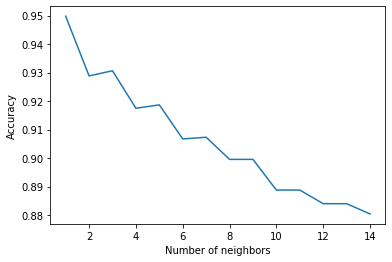

In [79]:
%matplotlib inline              
import matplotlib.pyplot as plt

#plot the relationship between no. of neighbors and Testing Accuracy
plt.plot(k_range,scores_list)
plt.xlabel('Number of neighbors')
plt.ylabel('Testing Accuracy')
plt.show()

In [82]:
#performing classification using knn classifier using 5 neigbors
knn = neighbors.KNeighborsClassifier(n_neighbors = 5)
%time knn.fit(X_train_dtm, y_train)
y_pred = knn.predict(X_test_dtm)
scores = metrics.accuracy_score(y_test, y_pred)
print("Testing accuracy for k = 5 is",scores )

Wall time: 5.99 ms
Testing accuracy for k = 5 is 0.9186602870813397
